Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
SEED = 144

Load train and test dataframes

In [3]:
train_df = pd.read_csv('data.files/train.csv')
print('Loaded train dataset: ', train_df.shape)

Loaded train dataset:  (106469, 896)


In [4]:
test_df = pd.read_csv('data.files/test.csv')
print('Loaded test dataset: ', test_df.shape)

Loaded test dataset:  (75856, 896)


In [5]:
val_df = pd.read_csv('data.files/val.csv')
print('Loaded validation dataset: ', val_df.shape)

Loaded validation dataset:  (71058, 896)


In [6]:
feature_cols = [c for c in test_df.columns if c not in ['file', 'obfuscator']]
feature_cols

['entropy;generic',
 'entropy;names',
 'entropy;values',
 'node_pairs;ArrayExpression->ArrayExpression',
 'node_pairs;ArrayExpression->ArrowFunctionExpression',
 'node_pairs;ArrayExpression->AssignmentExpression',
 'node_pairs;ArrayExpression->AwaitExpression',
 'node_pairs;ArrayExpression->BinaryExpression',
 'node_pairs;ArrayExpression->CallExpression',
 'node_pairs;ArrayExpression->ConditionalExpression',
 'node_pairs;ArrayExpression->FunctionExpression',
 'node_pairs;ArrayExpression->Identifier',
 'node_pairs;ArrayExpression->Literal',
 'node_pairs;ArrayExpression->LogicalExpression',
 'node_pairs;ArrayExpression->MemberExpression',
 'node_pairs;ArrayExpression->NewExpression',
 'node_pairs;ArrayExpression->ObjectExpression',
 'node_pairs;ArrayExpression->SequenceExpression',
 'node_pairs;ArrayExpression->SpreadElement',
 'node_pairs;ArrayExpression->TaggedTemplateExpression',
 'node_pairs;ArrayExpression->TemplateLiteral',
 'node_pairs;ArrayExpression->ThisExpression',
 'node_pair

# Train and evaluate models

## Train classifiation model

In [9]:
from sklearn import metrics
from catboost import CatBoostClassifier


np.random.seed(SEED)

feature_cols = [c for c in test_df.columns if c not in ['file', 'obfuscator']]

X_train = train_df[feature_cols].to_numpy()
X_test = test_df[feature_cols].to_numpy()
X_val = val_df[feature_cols].to_numpy()

y_train = train_df['obfuscator'].to_numpy()
y_test = test_df['obfuscator'].to_numpy()
y_val = val_df['obfuscator'].to_numpy()

In [10]:
model = CatBoostClassifier(
    iterations=50,
    depth=5,
    learning_rate=0.3,
    loss_function='MultiClassOneVsAll',
    verbose=True,
    random_seed=SEED,
)


model.fit(X_train, y_train, eval_set=(X_val, y_val))


preds_class = model.predict(X_test)
print(metrics.classification_report(y_test, preds_class, digits=4))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.4583179	test: 0.4582276	best: 0.4582276 (0)	total: 699ms	remaining: 34.2s
1:	learn: 0.3245309	test: 0.3243378	best: 0.3243378 (1)	total: 1.23s	remaining: 29.4s
2:	learn: 0.2396164	test: 0.2394719	best: 0.2394719 (2)	total: 1.77s	remaining: 27.8s
3:	learn: 0.1759065	test: 0.1757870	best: 0.1757870 (3)	total: 2.35s	remaining: 27.1s
4:	learn: 0.1353490	test: 0.1352910	best: 0.1352910 (4)	total: 2.92s	remaining: 26.3s
5:	learn: 0.1042353	test: 0.1041617	best: 0.1041617 (5)	total: 3.49s	remaining: 25.6s
6:	learn: 0.0821636	test: 0.0820825	best: 0.0820825 (6)	total: 4.01s	remaining: 24.7s
7:	learn: 0.0672671	test: 0.0671769	best: 0.0671769 (7)	total: 4.45s	remaining: 23.4s
8:	learn: 0.0543134	test: 0.0542015	best: 0.0542015 (8)	total: 5.01s	remaining: 22.8s
9:	learn: 0.0441846	test: 0.0440918	best: 0.0440918 (9)	total: 5.48s	remaining: 21.9s
10:	learn: 0.0367816	test: 0.0366939	best: 0.0366939 (10)	total: 6.01s	remaining: 21.3s
11:	learn: 0.0310488	test: 0.0309403	best: 0.0309403

In [11]:
features_importance_arr = model.get_feature_importance()
top_importance = sorted(
    [x for x in zip(features_importance_arr, feature_cols)],
    reverse=True,
    key=lambda x: x[0]
)
top_importance[:100]

[(16.0537143987039, 'ratios;chars_newlines'),
 (9.946049180335915, 'ratios;chars_whitespaces'),
 (7.726563347526418, 'node_pairs;Program->ExpressionStatement'),
 (5.347634051868141, 'ratios;reserved_names_fromCharCode'),
 (4.457935634615965, 'nodes;EmptyStatement'),
 (4.098936472747387, 'ratios;chars_names_ascii_letters'),
 (3.8836907389616573, 'node_pairs;Program->FunctionDeclaration'),
 (3.6680923091820774, 'ratios;chars_names_ascii_lowercase'),
 (2.7754830975659988, 'node_pairs;Program->EmptyStatement'),
 (2.5044385626997947, 'ratios;chars_names_digits'),
 (2.1999834430540366, 'ratios;chars_names_another'),
 (2.049166241584017, 'node_pairs;CallExpression->FunctionExpression'),
 (1.546141225197002, 'node_pairs;MemberExpression->CallExpression'),
 (1.5384380808851976, 'node_pairs;BlockStatement->FunctionDeclaration'),
 (1.4703154514412071, 'node_pairs;ExpressionStatement->AssignmentExpression'),
 (1.415012154325745, 'ratios;names_quantile_80'),
 (1.4049134937666246, 'node_pairs;Functi

## Save feature columns

In [ ]:
import json

with open('data.files/feature_columns.json', 'w') as f:
    json.dump(feature_cols, f)

## Save classification model

In [ ]:
model.save_model('data.files/classification_model.save')

# Train detecton model

In [12]:
from sklearn import metrics
from catboost import CatBoostClassifier


np.random.seed(SEED)

feature_cols = [c for c in test_df.columns if c not in ['file', 'obfuscator']]

X_train = train_df[feature_cols].to_numpy()
X_test = test_df[feature_cols].to_numpy()
X_val = val_df[feature_cols].to_numpy()

y_train = train_df['obfuscator'].to_numpy()
y_test = test_df['obfuscator'].to_numpy()
y_val = val_df['obfuscator'].to_numpy()

In [13]:
def create_binary_target(a: np.array):
    return np.array([0 if x == 'original' else 1 for x in a])

y_train = create_binary_target(y_train)
y_test = create_binary_target(y_test)
y_val = create_binary_target(y_val)


In [14]:
model = CatBoostClassifier(
    iterations=15,
    depth=5, 
    learning_rate=0.05, 
    loss_function='Logloss', verbose=True, random_seed=SEED, 
    od_type='Iter',
    od_wait=70,
    eval_metric='Recall',
)


model.fit(X_train, y_train, eval_set=(X_val, y_val))


preds_class = model.predict(X_test)
print(metrics.classification_report(y_test, preds_class, digits=4))

0:	learn: 0.9933753	test: 0.9933277	best: 0.9933277 (0)	total: 74.2ms	remaining: 1.04s
1:	learn: 0.9920503	test: 0.9927529	best: 0.9933277 (0)	total: 151ms	remaining: 981ms
2:	learn: 0.9949015	test: 0.9947521	best: 0.9947521 (2)	total: 221ms	remaining: 885ms
3:	learn: 0.9952034	test: 0.9952019	best: 0.9952019 (3)	total: 291ms	remaining: 800ms
4:	learn: 0.9954046	test: 0.9953519	best: 0.9953519 (4)	total: 364ms	remaining: 727ms
5:	learn: 0.9953040	test: 0.9955268	best: 0.9955268 (5)	total: 434ms	remaining: 652ms
6:	learn: 0.9951027	test: 0.9954268	best: 0.9955268 (5)	total: 505ms	remaining: 577ms
7:	learn: 0.9944822	test: 0.9948521	best: 0.9955268 (5)	total: 581ms	remaining: 509ms
8:	learn: 0.9947841	test: 0.9950020	best: 0.9955268 (5)	total: 657ms	remaining: 438ms
9:	learn: 0.9951530	test: 0.9954518	best: 0.9955268 (5)	total: 733ms	remaining: 367ms
10:	learn: 0.9954717	test: 0.9956767	best: 0.9956767 (10)	total: 809ms	remaining: 294ms
11:	learn: 0.9958742	test: 0.9960266	best: 0.996026

## Save detection model

In [ ]:
model.save_model('data.files/detection_model.save')

# Blind detection

In [15]:
OBFUSCATORS = sorted(set(train_df['obfuscator']) - {'original'})

for obfuscator in OBFUSCATORS:
    X_train = train_df[train_df['obfuscator'] != obfuscator][feature_cols].to_numpy()
    X_test = test_df[test_df['obfuscator'] != obfuscator][feature_cols].to_numpy()
    X_test_obf = test_df[test_df['obfuscator'] == obfuscator][feature_cols].to_numpy()
    X_val = val_df[val_df['obfuscator'] != obfuscator][feature_cols].to_numpy()

    y_train = train_df[train_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test = test_df[test_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test_obf = test_df[test_df['obfuscator'] == obfuscator]['obfuscator'].to_numpy()
    y_val = val_df[val_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()

    def create_binary_target(a: np.array):
        return np.array([0 if x == 'original' else 1 for x in a])

    y_train = create_binary_target(y_train)
    y_test = create_binary_target(y_test)
    y_test_obf = create_binary_target(y_test_obf)
    y_val = create_binary_target(y_val)


    print('!!!! ' + obfuscator)
                       
    model = CatBoostClassifier(
        iterations=15,
        depth=5, 
        learning_rate=0.2, 
        loss_function='Logloss', verbose=True, random_seed=SEED, 
        od_type='Iter',
        od_wait=70,
    )

    model.fit(X_train, 
              y_train, 
              sample_weight=[0.9 if y == 0 else 1.0 for y in y_train],
              eval_set=(X_val, y_val), 
              use_best_model=False
    )

    preds_class = model.predict(X_test)
    print(metrics.classification_report(y_test, preds_class, digits=4))
    
    print('!!!! ' + obfuscator)
    preds_class = model.predict(X_test_obf)
    print(metrics.classification_report(y_test_obf, preds_class, digits=4))

!!!! closure
0:	learn: 0.2987339	test: 0.2966513	best: 0.2966513 (0)	total: 74.8ms	remaining: 1.05s
1:	learn: 0.1419828	test: 0.1408139	best: 0.1408139 (1)	total: 143ms	remaining: 927ms
2:	learn: 0.0997007	test: 0.0989391	best: 0.0989391 (2)	total: 212ms	remaining: 848ms
3:	learn: 0.0681262	test: 0.0672370	best: 0.0672370 (3)	total: 278ms	remaining: 764ms
4:	learn: 0.0525204	test: 0.0518813	best: 0.0518813 (4)	total: 346ms	remaining: 691ms
5:	learn: 0.0388547	test: 0.0384773	best: 0.0384773 (5)	total: 414ms	remaining: 622ms
6:	learn: 0.0332621	test: 0.0329286	best: 0.0329286 (6)	total: 473ms	remaining: 540ms
7:	learn: 0.0270646	test: 0.0269070	best: 0.0269070 (7)	total: 545ms	remaining: 477ms
8:	learn: 0.0256993	test: 0.0256967	best: 0.0256967 (8)	total: 596ms	remaining: 397ms
9:	learn: 0.0242773	test: 0.0243207	best: 0.0243207 (9)	total: 654ms	remaining: 327ms
10:	learn: 0.0225097	test: 0.0226377	best: 0.0226377 (10)	total: 725ms	remaining: 264ms
11:	learn: 0.0214589	test: 0.0216891	b

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! defendjs
0:	learn: 0.3183631	test: 0.3177916	best: 0.3177916 (0)	total: 77.4ms	remaining: 1.08s
1:	learn: 0.1586122	test: 0.1579325	best: 0.1579325 (1)	total: 144ms	remaining: 936ms
2:	learn: 0.0998635	test: 0.0987024	best: 0.0987024 (2)	total: 207ms	remaining: 827ms
3:	learn: 0.0619770	test: 0.0606865	best: 0.0606865 (3)	total: 268ms	remaining: 738ms
4:	learn: 0.0486227	test: 0.0475553	best: 0.0475553 (4)	total: 332ms	remaining: 663ms
5:	learn: 0.0389528	test: 0.0380162	best: 0.0380162 (5)	total: 404ms	remaining: 605ms
6:	learn: 0.0350176	test: 0.0341954	best: 0.0341954 (6)	total: 456ms	remaining: 521ms
7:	learn: 0.0301500	test: 0.0294848	best: 0.0294848 (7)	total: 519ms	remaining: 454ms
8:	learn: 0.0284538	test: 0.0279883	best: 0.0279883 (8)	total: 586ms	remaining: 391ms
9:	learn: 0.0253099	test: 0.0248153	best: 0.0248153 (9)	total: 644ms	remaining: 322ms
10:	learn: 0.0234767	test: 0.0229737	best: 0.0229737 (10)	total: 692ms	remaining: 252ms
11:	learn: 0.0223950	test: 0.0219685	

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! gnirts
0:	learn: 0.3158259	test: 0.3152035	best: 0.3152035 (0)	total: 72.6ms	remaining: 1.01s
1:	learn: 0.1764322	test: 0.1766098	best: 0.1766098 (1)	total: 138ms	remaining: 900ms
2:	learn: 0.1023962	test: 0.1023681	best: 0.1023681 (2)	total: 221ms	remaining: 884ms
3:	learn: 0.0733197	test: 0.0731803	best: 0.0731803 (3)	total: 298ms	remaining: 819ms
4:	learn: 0.0504867	test: 0.0501690	best: 0.0501690 (4)	total: 368ms	remaining: 737ms
5:	learn: 0.0429484	test: 0.0426245	best: 0.0426245 (5)	total: 434ms	remaining: 650ms
6:	learn: 0.0365784	test: 0.0362498	best: 0.0362498 (6)	total: 493ms	remaining: 563ms
7:	learn: 0.0302639	test: 0.0297333	best: 0.0297333 (7)	total: 559ms	remaining: 489ms
8:	learn: 0.0277210	test: 0.0272363	best: 0.0272363 (8)	total: 613ms	remaining: 408ms
9:	learn: 0.0263752	test: 0.0260021	best: 0.0260021 (9)	total: 673ms	remaining: 337ms
10:	learn: 0.0249703	test: 0.0246716	best: 0.0246716 (10)	total: 728ms	remaining: 265ms
11:	learn: 0.0238788	test: 0.0235860	be

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jfogs
0:	learn: 0.2980516	test: 0.2973699	best: 0.2973699 (0)	total: 79.4ms	remaining: 1.11s
1:	learn: 0.1374141	test: 0.1370848	best: 0.1370848 (1)	total: 142ms	remaining: 922ms
2:	learn: 0.0727943	test: 0.0717979	best: 0.0717979 (2)	total: 206ms	remaining: 825ms
3:	learn: 0.0498256	test: 0.0489111	best: 0.0489111 (3)	total: 269ms	remaining: 740ms
4:	learn: 0.0373428	test: 0.0364202	best: 0.0364202 (4)	total: 345ms	remaining: 690ms
5:	learn: 0.0314945	test: 0.0306494	best: 0.0306494 (5)	total: 416ms	remaining: 624ms
6:	learn: 0.0286148	test: 0.0280113	best: 0.0280113 (6)	total: 480ms	remaining: 549ms
7:	learn: 0.0222670	test: 0.0217604	best: 0.0217604 (7)	total: 545ms	remaining: 477ms
8:	learn: 0.0202410	test: 0.0197905	best: 0.0197905 (8)	total: 602ms	remaining: 401ms
9:	learn: 0.0188269	test: 0.0185030	best: 0.0185030 (9)	total: 664ms	remaining: 332ms
10:	learn: 0.0177175	test: 0.0174484	best: 0.0174484 (10)	total: 724ms	remaining: 263ms
11:	learn: 0.0172065	test: 0.0170327	bes

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jscrewit
0:	learn: 0.3166124	test: 0.3151180	best: 0.3151180 (0)	total: 74.5ms	remaining: 1.04s
1:	learn: 0.1699268	test: 0.1680461	best: 0.1680461 (1)	total: 144ms	remaining: 936ms
2:	learn: 0.0896860	test: 0.0879749	best: 0.0879749 (2)	total: 204ms	remaining: 814ms
3:	learn: 0.0590607	test: 0.0577197	best: 0.0577197 (3)	total: 274ms	remaining: 753ms
4:	learn: 0.0464121	test: 0.0454613	best: 0.0454613 (4)	total: 340ms	remaining: 679ms
5:	learn: 0.0393447	test: 0.0385014	best: 0.0385014 (5)	total: 409ms	remaining: 613ms
6:	learn: 0.0325711	test: 0.0318699	best: 0.0318699 (6)	total: 477ms	remaining: 545ms
7:	learn: 0.0314421	test: 0.0309414	best: 0.0309414 (7)	total: 523ms	remaining: 458ms
8:	learn: 0.0284938	test: 0.0280041	best: 0.0280041 (8)	total: 591ms	remaining: 394ms
9:	learn: 0.0272239	test: 0.0268304	best: 0.0268304 (9)	total: 652ms	remaining: 326ms
10:	learn: 0.0256685	test: 0.0254469	best: 0.0254469 (10)	total: 729ms	remaining: 265ms
11:	learn: 0.0235929	test: 0.0233584	

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/an

!!!! jsobfu
0:	learn: 0.2730208	test: 0.2712524	best: 0.2712524 (0)	total: 77.2ms	remaining: 1.08s
1:	learn: 0.1371321	test: 0.1364602	best: 0.1364602 (1)	total: 144ms	remaining: 938ms
2:	learn: 0.0783872	test: 0.0773968	best: 0.0773968 (2)	total: 214ms	remaining: 855ms
3:	learn: 0.0552182	test: 0.0543369	best: 0.0543369 (3)	total: 279ms	remaining: 768ms
4:	learn: 0.0393696	test: 0.0388393	best: 0.0388393 (4)	total: 347ms	remaining: 694ms
5:	learn: 0.0331547	test: 0.0327777	best: 0.0327777 (5)	total: 420ms	remaining: 630ms
6:	learn: 0.0298136	test: 0.0295593	best: 0.0295593 (6)	total: 490ms	remaining: 560ms
7:	learn: 0.0259061	test: 0.0256261	best: 0.0256261 (7)	total: 555ms	remaining: 485ms
8:	learn: 0.0245742	test: 0.0244145	best: 0.0244145 (8)	total: 612ms	remaining: 408ms
9:	learn: 0.0236858	test: 0.0235748	best: 0.0235748 (9)	total: 659ms	remaining: 330ms
10:	learn: 0.0228264	test: 0.0228938	best: 0.0228938 (10)	total: 712ms	remaining: 259ms
11:	learn: 0.0223465	test: 0.0224776	be

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! uglifyjs
0:	learn: 0.2966842	test: 0.2968450	best: 0.2968450 (0)	total: 77.8ms	remaining: 1.09s
1:	learn: 0.1722625	test: 0.1721185	best: 0.1721185 (1)	total: 143ms	remaining: 929ms
2:	learn: 0.0959212	test: 0.0960546	best: 0.0960546 (2)	total: 203ms	remaining: 812ms
3:	learn: 0.0540904	test: 0.0542077	best: 0.0542077 (3)	total: 269ms	remaining: 740ms
4:	learn: 0.0425601	test: 0.0428392	best: 0.0428392 (4)	total: 327ms	remaining: 654ms
5:	learn: 0.0357863	test: 0.0361458	best: 0.0361458 (5)	total: 387ms	remaining: 580ms
6:	learn: 0.0280412	test: 0.0285056	best: 0.0285056 (6)	total: 447ms	remaining: 511ms
7:	learn: 0.0240205	test: 0.0245696	best: 0.0245696 (7)	total: 507ms	remaining: 443ms
8:	learn: 0.0191836	test: 0.0196877	best: 0.0196877 (8)	total: 562ms	remaining: 375ms
9:	learn: 0.0174906	test: 0.0178773	best: 0.0178773 (9)	total: 614ms	remaining: 307ms
10:	learn: 0.0162831	test: 0.0167127	best: 0.0167127 (10)	total: 662ms	remaining: 241ms
11:	learn: 0.0145626	test: 0.0149542	

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Detection lexical features only

In [16]:
lexical_features = [
    f for f in feature_cols 
    if not f.startswith('node')
    and not f in ['v_types', 'e_types']
]
lexical_features

['entropy;generic',
 'entropy;names',
 'entropy;values',
 'ratios;chars_another',
 'ratios;chars_ascii_letters',
 'ratios;chars_ascii_lowercase',
 'ratios;chars_ascii_uppercase',
 'ratios;chars_backslash',
 'ratios;chars_digits',
 'ratios;chars_names_another',
 'ratios;chars_names_ascii_letters',
 'ratios;chars_names_ascii_lowercase',
 'ratios;chars_names_ascii_uppercase',
 'ratios;chars_names_backslash',
 'ratios;chars_names_digits',
 'ratios;chars_names_newlines',
 'ratios;chars_names_whitespaces',
 'ratios;chars_newlines',
 'ratios;chars_values_another',
 'ratios;chars_values_ascii_letters',
 'ratios;chars_values_ascii_lowercase',
 'ratios;chars_values_ascii_uppercase',
 'ratios;chars_values_backslash',
 'ratios;chars_values_digits',
 'ratios;chars_values_newlines',
 'ratios;chars_values_whitespaces',
 'ratios;chars_whitespaces',
 'ratios;keywords_else',
 'ratios;keywords_finally',
 'ratios;names_quantile_0',
 'ratios;names_quantile_10',
 'ratios;names_quantile_100',
 'ratios;names_

In [18]:
OBFUSCATORS = sorted(set(train_df['obfuscator']) - {'original'})

for obfuscator in OBFUSCATORS:
    X_train = train_df[train_df['obfuscator'] != obfuscator][lexical_features].to_numpy()
    X_test = test_df[test_df['obfuscator'] != obfuscator][lexical_features].to_numpy()
    X_test_obf = test_df[test_df['obfuscator'] == obfuscator][lexical_features].to_numpy()
    X_val = val_df[val_df['obfuscator'] != obfuscator][lexical_features].to_numpy()

    y_train = train_df[train_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test = test_df[test_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test_obf = test_df[test_df['obfuscator'] == obfuscator]['obfuscator'].to_numpy()
    y_val = val_df[val_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()

    def create_binary_target(a: np.array):
        return np.array([0 if x == 'original' else 1 for x in a])

    y_train = create_binary_target(y_train)
    y_test = create_binary_target(y_test)
    y_test_obf = create_binary_target(y_test_obf)
    y_val = create_binary_target(y_val)


    print('!!!! ' + obfuscator)
                       
    model = CatBoostClassifier(
        iterations=15,
        depth=5, 
        learning_rate=0.2, 
        loss_function='Logloss', verbose=True, random_seed=SEED, 
        od_type='Iter',
        od_wait=70,
    )

    model.fit(X_train,
              y_train, 
              sample_weight=[0.9 if y == 0 else 1.0 for y in y_train],
              eval_set=(X_val, y_val), 
              use_best_model=False
    )

    preds_class = model.predict(X_test)
    print(metrics.classification_report(y_test, preds_class, digits=4))
    
    print('!!!! ' + obfuscator)
    preds_class = model.predict(X_test_obf)
    print(metrics.classification_report(y_test_obf, preds_class, digits=4))

!!!! closure
0:	learn: 0.3632901	test: 0.3635864	best: 0.3635864 (0)	total: 21.3ms	remaining: 298ms
1:	learn: 0.2254209	test: 0.2243564	best: 0.2243564 (1)	total: 37.4ms	remaining: 243ms
2:	learn: 0.1276769	test: 0.1263568	best: 0.1263568 (2)	total: 53.2ms	remaining: 213ms
3:	learn: 0.0941019	test: 0.0927055	best: 0.0927055 (3)	total: 68.7ms	remaining: 189ms
4:	learn: 0.0783882	test: 0.0772297	best: 0.0772297 (4)	total: 83.2ms	remaining: 166ms
5:	learn: 0.0649688	test: 0.0638132	best: 0.0638132 (5)	total: 98.7ms	remaining: 148ms
6:	learn: 0.0564217	test: 0.0553294	best: 0.0553294 (6)	total: 114ms	remaining: 131ms
7:	learn: 0.0510630	test: 0.0500939	best: 0.0500939 (7)	total: 130ms	remaining: 114ms
8:	learn: 0.0419909	test: 0.0411125	best: 0.0411125 (8)	total: 146ms	remaining: 97ms
9:	learn: 0.0357783	test: 0.0347875	best: 0.0347875 (9)	total: 162ms	remaining: 81ms
10:	learn: 0.0342081	test: 0.0332784	best: 0.0332784 (10)	total: 176ms	remaining: 63.9ms
11:	learn: 0.0318115	test: 0.03070

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! defendjs
0:	learn: 0.3730394	test: 0.3713448	best: 0.3713448 (0)	total: 18.6ms	remaining: 261ms
1:	learn: 0.2215264	test: 0.2198007	best: 0.2198007 (1)	total: 35.1ms	remaining: 228ms
2:	learn: 0.1557391	test: 0.1549165	best: 0.1549165 (2)	total: 50.5ms	remaining: 202ms
3:	learn: 0.1156366	test: 0.1147746	best: 0.1147746 (3)	total: 65.5ms	remaining: 180ms
4:	learn: 0.0888852	test: 0.0883008	best: 0.0883008 (4)	total: 82.7ms	remaining: 165ms
5:	learn: 0.0729143	test: 0.0723203	best: 0.0723203 (5)	total: 98ms	remaining: 147ms
6:	learn: 0.0580665	test: 0.0572716	best: 0.0572716 (6)	total: 113ms	remaining: 129ms
7:	learn: 0.0505748	test: 0.0499672	best: 0.0499672 (7)	total: 128ms	remaining: 112ms
8:	learn: 0.0433919	test: 0.0429852	best: 0.0429852 (8)	total: 142ms	remaining: 94.6ms
9:	learn: 0.0388475	test: 0.0383964	best: 0.0383964 (9)	total: 156ms	remaining: 78ms
10:	learn: 0.0376436	test: 0.0373775	best: 0.0373775 (10)	total: 168ms	remaining: 61.2ms
11:	learn: 0.0345195	test: 0.0343

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! gnirts
0:	learn: 0.4207534	test: 0.4205076	best: 0.4205076 (0)	total: 15.1ms	remaining: 211ms
1:	learn: 0.2239496	test: 0.2221793	best: 0.2221793 (1)	total: 29.6ms	remaining: 192ms
2:	learn: 0.1470928	test: 0.1459622	best: 0.1459622 (2)	total: 44.3ms	remaining: 177ms
3:	learn: 0.1056510	test: 0.1039815	best: 0.1039815 (3)	total: 60.3ms	remaining: 166ms
4:	learn: 0.0822363	test: 0.0805216	best: 0.0805216 (4)	total: 75.2ms	remaining: 150ms
5:	learn: 0.0686965	test: 0.0674717	best: 0.0674717 (5)	total: 89.3ms	remaining: 134ms
6:	learn: 0.0602239	test: 0.0591247	best: 0.0591247 (6)	total: 104ms	remaining: 119ms
7:	learn: 0.0540722	test: 0.0532466	best: 0.0532466 (7)	total: 118ms	remaining: 104ms
8:	learn: 0.0475697	test: 0.0465989	best: 0.0465989 (8)	total: 134ms	remaining: 89.2ms
9:	learn: 0.0436393	test: 0.0427370	best: 0.0427370 (9)	total: 147ms	remaining: 73.6ms
10:	learn: 0.0406791	test: 0.0396417	best: 0.0396417 (10)	total: 160ms	remaining: 58.2ms
11:	learn: 0.0390912	test: 0.03

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jfogs
0:	learn: 0.3225422	test: 0.3221395	best: 0.3221395 (0)	total: 17.6ms	remaining: 246ms
1:	learn: 0.1626802	test: 0.1606682	best: 0.1606682 (1)	total: 33ms	remaining: 214ms
2:	learn: 0.0892973	test: 0.0870928	best: 0.0870928 (2)	total: 48.2ms	remaining: 193ms
3:	learn: 0.0663015	test: 0.0645101	best: 0.0645101 (3)	total: 63.6ms	remaining: 175ms
4:	learn: 0.0541420	test: 0.0525068	best: 0.0525068 (4)	total: 78ms	remaining: 156ms
5:	learn: 0.0365582	test: 0.0347179	best: 0.0347179 (5)	total: 93.1ms	remaining: 140ms
6:	learn: 0.0325465	test: 0.0309824	best: 0.0309824 (6)	total: 113ms	remaining: 129ms
7:	learn: 0.0298683	test: 0.0283760	best: 0.0283760 (7)	total: 131ms	remaining: 114ms
8:	learn: 0.0276437	test: 0.0263271	best: 0.0263271 (8)	total: 146ms	remaining: 97.1ms
9:	learn: 0.0254970	test: 0.0241383	best: 0.0241383 (9)	total: 163ms	remaining: 81.3ms
10:	learn: 0.0234156	test: 0.0222289	best: 0.0222289 (10)	total: 178ms	remaining: 64.7ms
11:	learn: 0.0221646	test: 0.0209497

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jscrewit
0:	learn: 0.3701946	test: 0.3704550	best: 0.3704550 (0)	total: 15.7ms	remaining: 219ms
1:	learn: 0.2112133	test: 0.2093960	best: 0.2093960 (1)	total: 31ms	remaining: 202ms
2:	learn: 0.1363275	test: 0.1349253	best: 0.1349253 (2)	total: 46.7ms	remaining: 187ms
3:	learn: 0.0955797	test: 0.0940595	best: 0.0940595 (3)	total: 62ms	remaining: 171ms
4:	learn: 0.0756937	test: 0.0743772	best: 0.0743772 (4)	total: 77.2ms	remaining: 154ms
5:	learn: 0.0607688	test: 0.0597421	best: 0.0597421 (5)	total: 91.6ms	remaining: 137ms
6:	learn: 0.0498732	test: 0.0490923	best: 0.0490923 (6)	total: 107ms	remaining: 122ms
7:	learn: 0.0444617	test: 0.0440133	best: 0.0440133 (7)	total: 122ms	remaining: 107ms
8:	learn: 0.0409599	test: 0.0405558	best: 0.0405558 (8)	total: 136ms	remaining: 90.8ms
9:	learn: 0.0376206	test: 0.0373199	best: 0.0373199 (9)	total: 149ms	remaining: 74.5ms
10:	learn: 0.0356662	test: 0.0354858	best: 0.0354858 (10)	total: 163ms	remaining: 59.3ms
11:	learn: 0.0320058	test: 0.0317

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/an

!!!! jsobfu
0:	learn: 0.4227434	test: 0.4202479	best: 0.4202479 (0)	total: 15.3ms	remaining: 214ms
1:	learn: 0.2194798	test: 0.2172923	best: 0.2172923 (1)	total: 30.3ms	remaining: 197ms
2:	learn: 0.1331617	test: 0.1318002	best: 0.1318002 (2)	total: 45.7ms	remaining: 183ms
3:	learn: 0.0880423	test: 0.0861670	best: 0.0861670 (3)	total: 61ms	remaining: 168ms
4:	learn: 0.0683149	test: 0.0666862	best: 0.0666862 (4)	total: 76ms	remaining: 152ms
5:	learn: 0.0558194	test: 0.0541419	best: 0.0541419 (5)	total: 93.7ms	remaining: 141ms
6:	learn: 0.0501742	test: 0.0488146	best: 0.0488146 (6)	total: 110ms	remaining: 125ms
7:	learn: 0.0458772	test: 0.0445344	best: 0.0445344 (7)	total: 124ms	remaining: 109ms
8:	learn: 0.0427720	test: 0.0416559	best: 0.0416559 (8)	total: 138ms	remaining: 91.8ms
9:	learn: 0.0402410	test: 0.0391403	best: 0.0391403 (9)	total: 152ms	remaining: 76ms
10:	learn: 0.0383267	test: 0.0373544	best: 0.0373544 (10)	total: 166ms	remaining: 60.5ms
11:	learn: 0.0365648	test: 0.0356674	

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! uglifyjs
0:	learn: 0.3419350	test: 0.3419772	best: 0.3419772 (0)	total: 15.5ms	remaining: 217ms
1:	learn: 0.2232606	test: 0.2225112	best: 0.2225112 (1)	total: 30.8ms	remaining: 200ms
2:	learn: 0.1428331	test: 0.1426642	best: 0.1426642 (2)	total: 45.5ms	remaining: 182ms
3:	learn: 0.1069969	test: 0.1066376	best: 0.1066376 (3)	total: 60.6ms	remaining: 167ms
4:	learn: 0.0754453	test: 0.0750163	best: 0.0750163 (4)	total: 75ms	remaining: 150ms
5:	learn: 0.0650610	test: 0.0648865	best: 0.0648865 (5)	total: 88.9ms	remaining: 133ms
6:	learn: 0.0551905	test: 0.0549155	best: 0.0549155 (6)	total: 103ms	remaining: 118ms
7:	learn: 0.0461397	test: 0.0460098	best: 0.0460098 (7)	total: 120ms	remaining: 105ms
8:	learn: 0.0429478	test: 0.0428593	best: 0.0428593 (8)	total: 134ms	remaining: 89.6ms
9:	learn: 0.0368993	test: 0.0366544	best: 0.0366544 (9)	total: 148ms	remaining: 74.1ms
10:	learn: 0.0356103	test: 0.0353688	best: 0.0353688 (10)	total: 162ms	remaining: 59ms
11:	learn: 0.0335259	test: 0.0333

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Detection syntactical features only

In [20]:
syntactical_features = [f for f in feature_cols if f not in lexical_features]
syntactical_features

['node_pairs;ArrayExpression->ArrayExpression',
 'node_pairs;ArrayExpression->ArrowFunctionExpression',
 'node_pairs;ArrayExpression->AssignmentExpression',
 'node_pairs;ArrayExpression->AwaitExpression',
 'node_pairs;ArrayExpression->BinaryExpression',
 'node_pairs;ArrayExpression->CallExpression',
 'node_pairs;ArrayExpression->ConditionalExpression',
 'node_pairs;ArrayExpression->FunctionExpression',
 'node_pairs;ArrayExpression->Identifier',
 'node_pairs;ArrayExpression->Literal',
 'node_pairs;ArrayExpression->LogicalExpression',
 'node_pairs;ArrayExpression->MemberExpression',
 'node_pairs;ArrayExpression->NewExpression',
 'node_pairs;ArrayExpression->ObjectExpression',
 'node_pairs;ArrayExpression->SequenceExpression',
 'node_pairs;ArrayExpression->SpreadElement',
 'node_pairs;ArrayExpression->TaggedTemplateExpression',
 'node_pairs;ArrayExpression->TemplateLiteral',
 'node_pairs;ArrayExpression->ThisExpression',
 'node_pairs;ArrayExpression->UnaryExpression',
 'node_pairs;ArrayEx

In [21]:
OBFUSCATORS = sorted(set(train_df['obfuscator']) - {'original'})

for obfuscator in OBFUSCATORS:
    X_train = train_df[train_df['obfuscator'] != obfuscator][syntactical_features].to_numpy()
    X_test = test_df[test_df['obfuscator'] != obfuscator][syntactical_features].to_numpy()
    X_test_obf = test_df[test_df['obfuscator'] == obfuscator][syntactical_features].to_numpy()
    X_val = val_df[val_df['obfuscator'] != obfuscator][syntactical_features].to_numpy()

    y_train = train_df[train_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test = test_df[test_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()
    y_test_obf = test_df[test_df['obfuscator'] == obfuscator]['obfuscator'].to_numpy()
    y_val = val_df[val_df['obfuscator'] != obfuscator]['obfuscator'].to_numpy()

    def create_binary_target(a: np.array):
        return np.array([0 if x == 'original' else 1 for x in a])

    y_train = create_binary_target(y_train)
    y_test = create_binary_target(y_test)
    y_test_obf = create_binary_target(y_test_obf)
    y_val = create_binary_target(y_val)


    print('!!!! ' + obfuscator)
                       
    model = CatBoostClassifier(
        iterations=15,
        depth=5, 
        learning_rate=0.2, 
        loss_function='Logloss', verbose=True, random_seed=SEED, 
        od_type='Iter',
        od_wait=70,
    )

    model.fit(X_train,
              y_train, 
              sample_weight=[0.9 if y == 0 else 1.0 for y in y_train],
              eval_set=(X_val, y_val), 
              use_best_model=False
    )

    preds_class = model.predict(X_test)
    print(metrics.classification_report(y_test, preds_class, digits=4))
    
    print('!!!! ' + obfuscator)
    preds_class = model.predict(X_test_obf)
    print(metrics.classification_report(y_test_obf, preds_class, digits=4))

!!!! closure
0:	learn: 0.4729787	test: 0.4734326	best: 0.4734326 (0)	total: 54.4ms	remaining: 761ms
1:	learn: 0.3548263	test: 0.3554372	best: 0.3554372 (1)	total: 102ms	remaining: 661ms
2:	learn: 0.2786308	test: 0.2786233	best: 0.2786233 (2)	total: 149ms	remaining: 595ms
3:	learn: 0.2385201	test: 0.2381449	best: 0.2381449 (3)	total: 199ms	remaining: 548ms
4:	learn: 0.2147526	test: 0.2137857	best: 0.2137857 (4)	total: 246ms	remaining: 492ms
5:	learn: 0.1970793	test: 0.1961941	best: 0.1961941 (5)	total: 298ms	remaining: 446ms
6:	learn: 0.1867890	test: 0.1855503	best: 0.1855503 (6)	total: 346ms	remaining: 395ms
7:	learn: 0.1772727	test: 0.1756315	best: 0.1756315 (7)	total: 395ms	remaining: 345ms
8:	learn: 0.1687955	test: 0.1672250	best: 0.1672250 (8)	total: 441ms	remaining: 294ms
9:	learn: 0.1632910	test: 0.1616010	best: 0.1616010 (9)	total: 486ms	remaining: 243ms
10:	learn: 0.1581762	test: 0.1565767	best: 0.1565767 (10)	total: 536ms	remaining: 195ms
11:	learn: 0.1523710	test: 0.1505458	b

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! defendjs
0:	learn: 0.4951485	test: 0.4953173	best: 0.4953173 (0)	total: 52.7ms	remaining: 737ms
1:	learn: 0.3700935	test: 0.3710138	best: 0.3710138 (1)	total: 101ms	remaining: 656ms
2:	learn: 0.3076754	test: 0.3079028	best: 0.3079028 (2)	total: 147ms	remaining: 588ms
3:	learn: 0.2661600	test: 0.2661513	best: 0.2661513 (3)	total: 196ms	remaining: 538ms
4:	learn: 0.2314146	test: 0.2313737	best: 0.2313737 (4)	total: 247ms	remaining: 493ms
5:	learn: 0.2133933	test: 0.2129833	best: 0.2129833 (5)	total: 301ms	remaining: 451ms
6:	learn: 0.1979593	test: 0.1973930	best: 0.1973930 (6)	total: 347ms	remaining: 397ms
7:	learn: 0.1885973	test: 0.1880142	best: 0.1880142 (7)	total: 389ms	remaining: 340ms
8:	learn: 0.1816850	test: 0.1809920	best: 0.1809920 (8)	total: 430ms	remaining: 287ms
9:	learn: 0.1749355	test: 0.1739440	best: 0.1739440 (9)	total: 476ms	remaining: 238ms
10:	learn: 0.1690047	test: 0.1681158	best: 0.1681158 (10)	total: 526ms	remaining: 191ms
11:	learn: 0.1635433	test: 0.1626241	

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! gnirts
0:	learn: 0.4885280	test: 0.4890900	best: 0.4890900 (0)	total: 51.8ms	remaining: 726ms
1:	learn: 0.3722011	test: 0.3723771	best: 0.3723771 (1)	total: 98.6ms	remaining: 641ms
2:	learn: 0.3117104	test: 0.3119318	best: 0.3119318 (2)	total: 142ms	remaining: 568ms
3:	learn: 0.2622573	test: 0.2626082	best: 0.2626082 (3)	total: 190ms	remaining: 524ms
4:	learn: 0.2343950	test: 0.2342717	best: 0.2342717 (4)	total: 242ms	remaining: 485ms
5:	learn: 0.2148914	test: 0.2145989	best: 0.2145989 (5)	total: 293ms	remaining: 440ms
6:	learn: 0.2032260	test: 0.2027075	best: 0.2027075 (6)	total: 339ms	remaining: 387ms
7:	learn: 0.1947950	test: 0.1938107	best: 0.1938107 (7)	total: 386ms	remaining: 338ms
8:	learn: 0.1882752	test: 0.1872668	best: 0.1872668 (8)	total: 431ms	remaining: 287ms
9:	learn: 0.1791224	test: 0.1780346	best: 0.1780346 (9)	total: 474ms	remaining: 237ms
10:	learn: 0.1733989	test: 0.1723350	best: 0.1723350 (10)	total: 520ms	remaining: 189ms
11:	learn: 0.1669707	test: 0.1658464	b

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jfogs
0:	learn: 0.4401001	test: 0.4414503	best: 0.4414503 (0)	total: 57.3ms	remaining: 803ms
1:	learn: 0.3271071	test: 0.3271973	best: 0.3271973 (1)	total: 105ms	remaining: 685ms
2:	learn: 0.2638608	test: 0.2638647	best: 0.2638647 (2)	total: 153ms	remaining: 612ms
3:	learn: 0.2272603	test: 0.2265879	best: 0.2265879 (3)	total: 196ms	remaining: 538ms
4:	learn: 0.1950177	test: 0.1942893	best: 0.1942893 (4)	total: 241ms	remaining: 482ms
5:	learn: 0.1808658	test: 0.1797048	best: 0.1797048 (5)	total: 288ms	remaining: 432ms
6:	learn: 0.1701939	test: 0.1687802	best: 0.1687802 (6)	total: 336ms	remaining: 384ms
7:	learn: 0.1649700	test: 0.1634483	best: 0.1634483 (7)	total: 378ms	remaining: 331ms
8:	learn: 0.1597091	test: 0.1580861	best: 0.1580861 (8)	total: 425ms	remaining: 283ms
9:	learn: 0.1556336	test: 0.1540248	best: 0.1540248 (9)	total: 471ms	remaining: 235ms
10:	learn: 0.1530975	test: 0.1514913	best: 0.1514913 (10)	total: 513ms	remaining: 186ms
11:	learn: 0.1506912	test: 0.1488602	bes

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! jscrewit
0:	learn: 0.4642653	test: 0.4659856	best: 0.4659856 (0)	total: 56.3ms	remaining: 788ms
1:	learn: 0.3365150	test: 0.3388143	best: 0.3388143 (1)	total: 109ms	remaining: 705ms
2:	learn: 0.2769770	test: 0.2789044	best: 0.2789044 (2)	total: 152ms	remaining: 606ms
3:	learn: 0.2350659	test: 0.2360187	best: 0.2360187 (3)	total: 197ms	remaining: 542ms
4:	learn: 0.2137442	test: 0.2141060	best: 0.2141060 (4)	total: 245ms	remaining: 489ms
5:	learn: 0.1998700	test: 0.2000055	best: 0.2000055 (5)	total: 293ms	remaining: 440ms
6:	learn: 0.1897461	test: 0.1897304	best: 0.1897304 (6)	total: 340ms	remaining: 388ms
7:	learn: 0.1813575	test: 0.1812009	best: 0.1812009 (7)	total: 383ms	remaining: 335ms
8:	learn: 0.1758734	test: 0.1756095	best: 0.1756095 (8)	total: 424ms	remaining: 283ms
9:	learn: 0.1680599	test: 0.1676681	best: 0.1676681 (9)	total: 471ms	remaining: 235ms
10:	learn: 0.1649911	test: 0.1645008	best: 0.1645008 (10)	total: 518ms	remaining: 188ms
11:	learn: 0.1617293	test: 0.1611588	

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/an

!!!! jsobfu
0:	learn: 0.4522305	test: 0.4522908	best: 0.4522908 (0)	total: 52ms	remaining: 728ms
1:	learn: 0.3261191	test: 0.3261899	best: 0.3261899 (1)	total: 99.4ms	remaining: 646ms
2:	learn: 0.2592105	test: 0.2585780	best: 0.2585780 (2)	total: 146ms	remaining: 586ms
3:	learn: 0.2205998	test: 0.2194622	best: 0.2194622 (3)	total: 193ms	remaining: 529ms
4:	learn: 0.1952054	test: 0.1938776	best: 0.1938776 (4)	total: 239ms	remaining: 478ms
5:	learn: 0.1825727	test: 0.1808305	best: 0.1808305 (5)	total: 285ms	remaining: 428ms
6:	learn: 0.1726685	test: 0.1707590	best: 0.1707590 (6)	total: 329ms	remaining: 376ms
7:	learn: 0.1650391	test: 0.1627913	best: 0.1627913 (7)	total: 375ms	remaining: 328ms
8:	learn: 0.1574228	test: 0.1549954	best: 0.1549954 (8)	total: 421ms	remaining: 280ms
9:	learn: 0.1528460	test: 0.1504416	best: 0.1504416 (9)	total: 468ms	remaining: 234ms
10:	learn: 0.1495999	test: 0.1473045	best: 0.1473045 (10)	total: 511ms	remaining: 186ms
11:	learn: 0.1456356	test: 0.1432980	bes

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


!!!! uglifyjs
0:	learn: 0.3872907	test: 0.3871854	best: 0.3871854 (0)	total: 49.1ms	remaining: 687ms
1:	learn: 0.2344718	test: 0.2349016	best: 0.2349016 (1)	total: 96.5ms	remaining: 627ms
2:	learn: 0.1688158	test: 0.1695443	best: 0.1695443 (2)	total: 141ms	remaining: 566ms
3:	learn: 0.1221057	test: 0.1231338	best: 0.1231338 (3)	total: 193ms	remaining: 531ms
4:	learn: 0.0983016	test: 0.0991609	best: 0.0991609 (4)	total: 243ms	remaining: 486ms
5:	learn: 0.0785169	test: 0.0794885	best: 0.0794885 (5)	total: 293ms	remaining: 440ms
6:	learn: 0.0683677	test: 0.0692951	best: 0.0692951 (6)	total: 342ms	remaining: 391ms
7:	learn: 0.0593057	test: 0.0603419	best: 0.0603419 (7)	total: 386ms	remaining: 338ms
8:	learn: 0.0528573	test: 0.0537946	best: 0.0537946 (8)	total: 431ms	remaining: 288ms
9:	learn: 0.0487099	test: 0.0495242	best: 0.0495242 (9)	total: 480ms	remaining: 240ms
10:	learn: 0.0444466	test: 0.0453372	best: 0.0453372 (10)	total: 525ms	remaining: 191ms
11:	learn: 0.0406943	test: 0.0415601

/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grigory/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 8
recall_ponom_lex =  [99,  0,     100,   53,   7,    0,     91.23,   85]
recall_ponom_synt = [20,  100,   100,   99,   27,   100,   0.5,     0.05]
recall_ponom =      [99,  100,   100,   99,   100,  100,   92,      1.18]

recall_ponom_lex = [x / 100 for x in recall_ponom_lex]
recall_ponom_synt = [x / 100 for x in recall_ponom_synt]
recall_ponom = [x / 100 for x in recall_ponom]

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
fig.set_dpi(600)

index = np.arange(n_groups) * 1
bar_width = 0.5

opacity = 0.7

rects_l = plt.bar(index - bar_width*(1/4), recall_ponom_lex, bar_width/4, alpha=1, color='blue', 
#                  label='Ponomarenko,\nKlyucharev')
                 label='This paper\n(lexical only)')
rects_s = plt.bar(index, recall_ponom_synt, bar_width/4, alpha=1, color='violet', 
#                  label='Ponomarenko,\nKlyucharev')
                 label='This paper\n(syntactical only)')
rects_all = plt.bar(index + bar_width*(1/4), recall_ponom, bar_width/4, alpha=1, color='red', 
#                  label='Ponomarenko,\nKlyucharev')
                 label='This paper')

plt.xlabel('Obfuscator')
plt.ylabel('Recall')
plt.title('Recall for unobserved obfuscator')
plt.xticks(
    index,
    ['closure', 'defendjs', 'gnirts', 'javascript-\nobfuscator', 
     'jfogs',   'jscrewit', 'jsobfu', 'uglifyjs'],
    rotation=45
)

plt.yticks([x/10 for x in range(0, 11, 2)])
plt.legend()
# plt.ylim(0, 1.5)
# plt.xlim(-0.5, np.max(index))
plt.grid(axis='y')

box = ax.get_position()

plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)

plt.tight_layout()
plt.show()

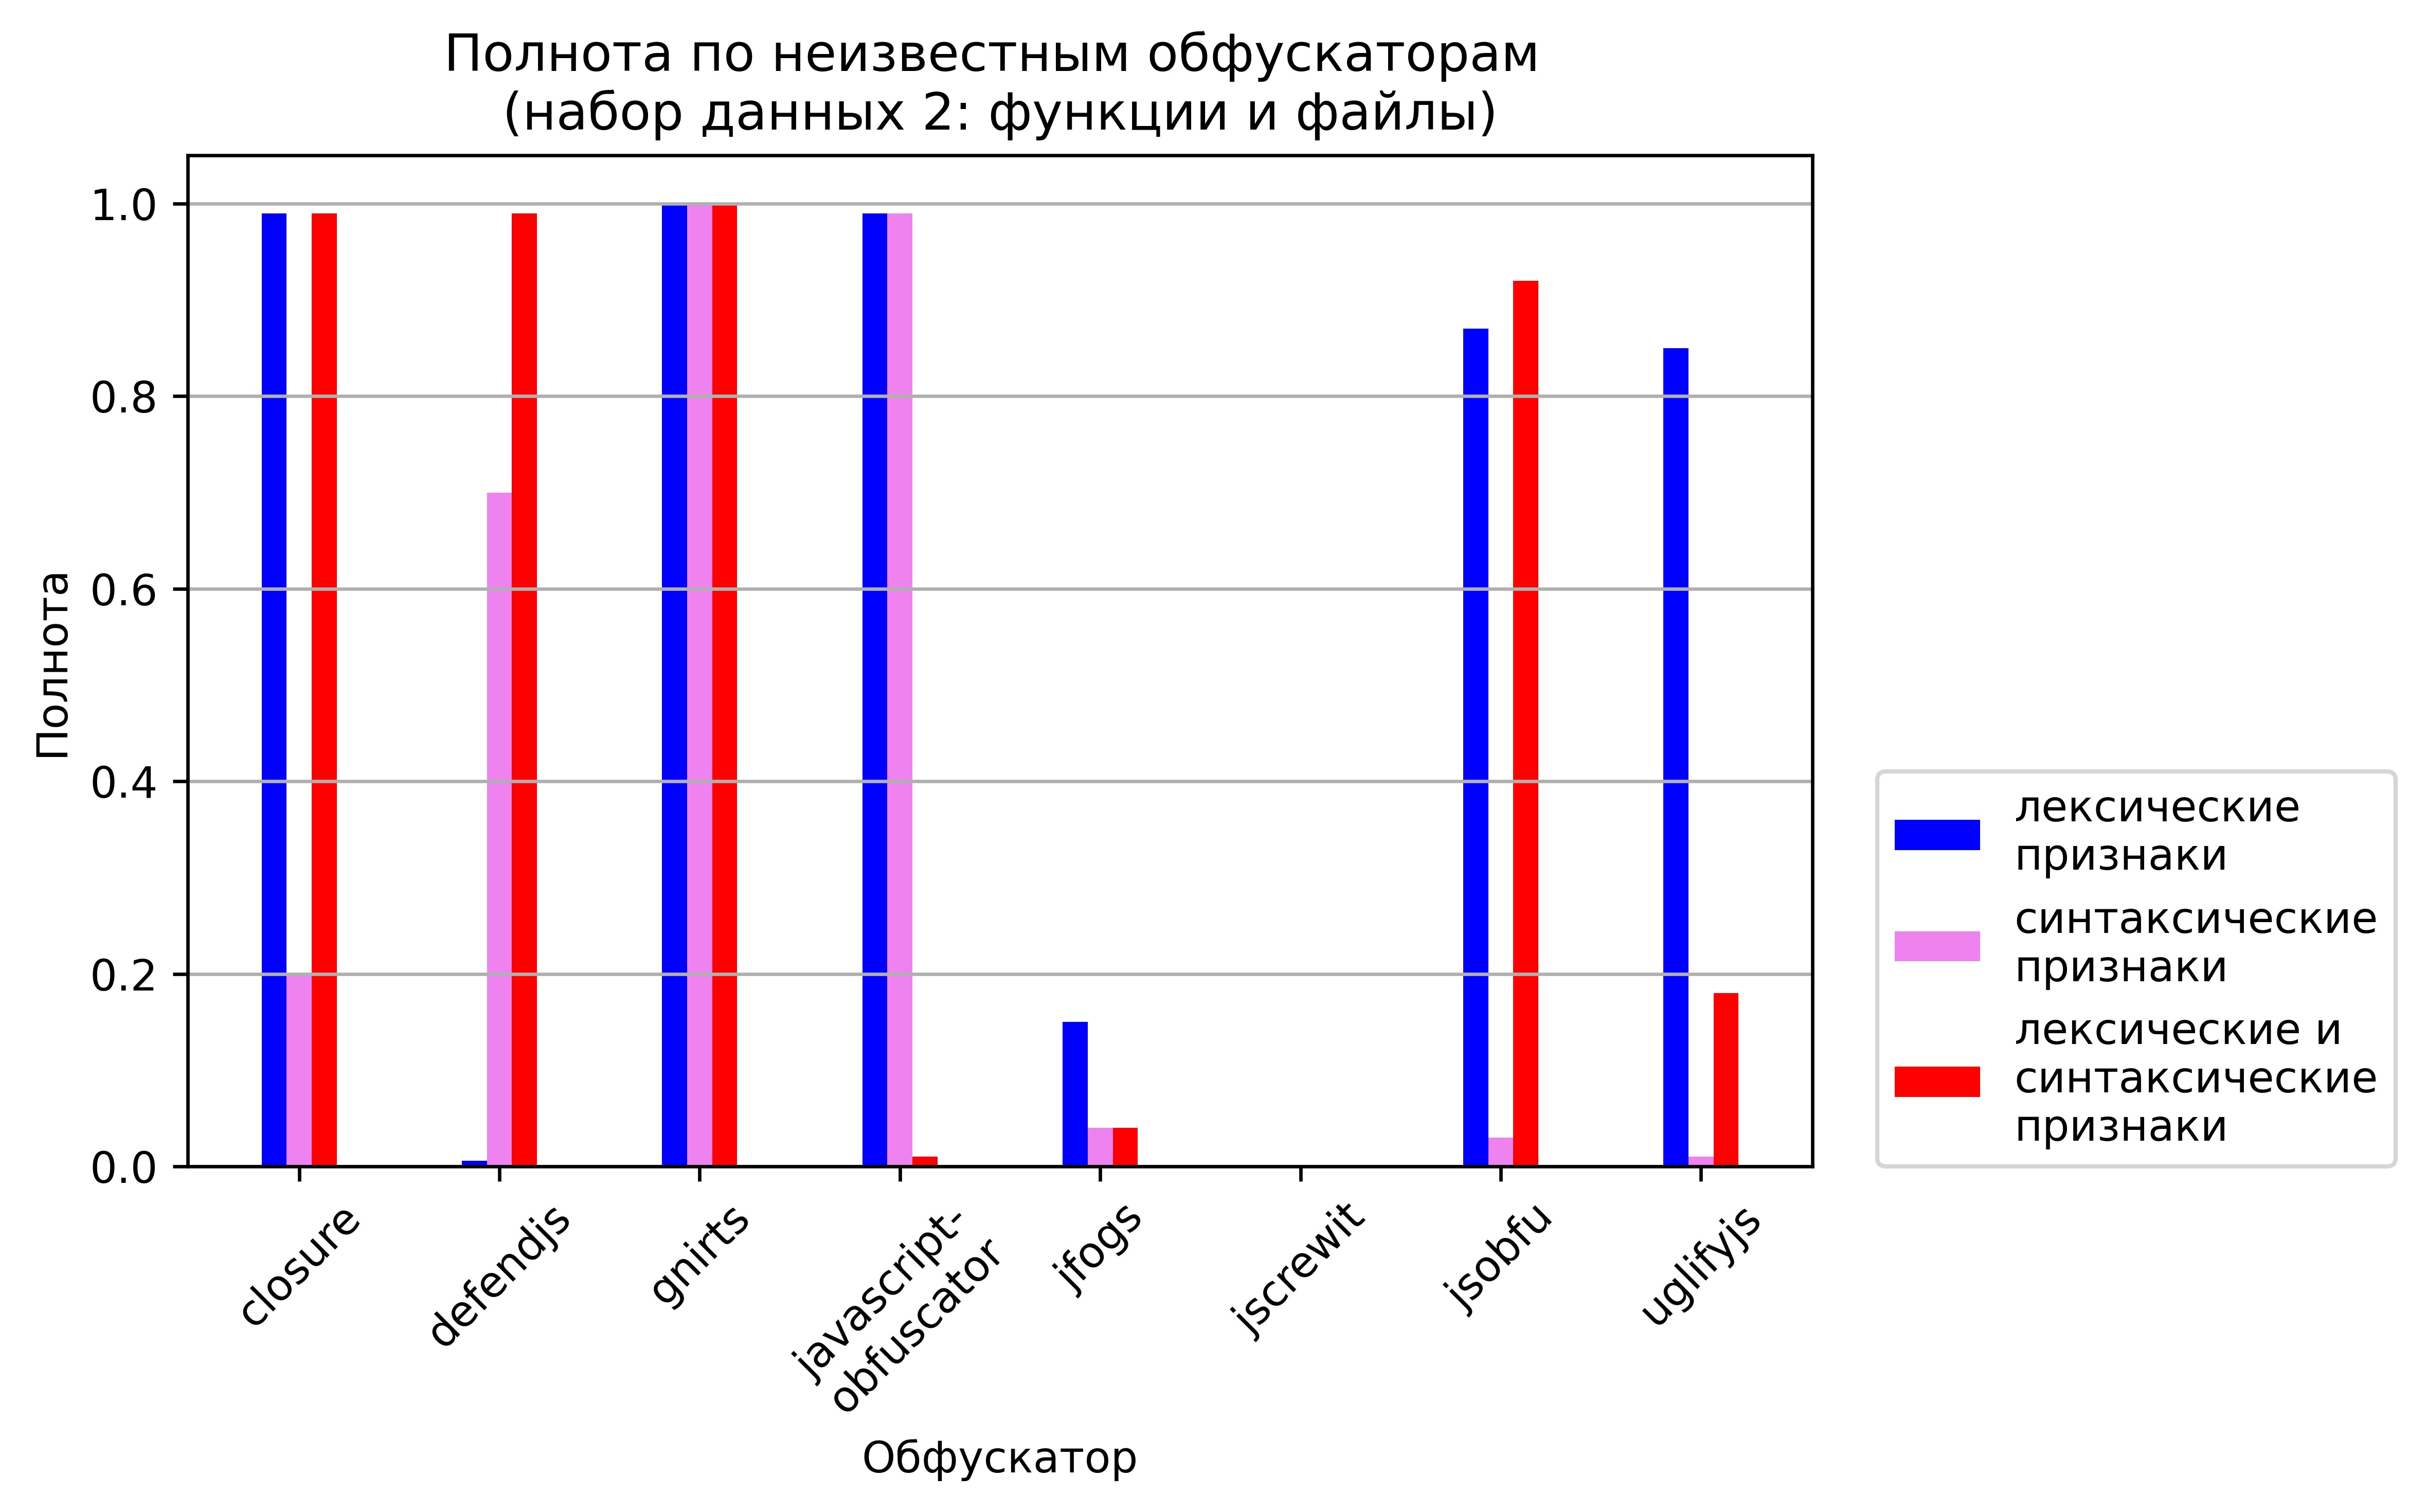

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 8
recall_ponom_lex =  [99,  0.6,   100,   99,    15,    0,   87,      85]
recall_ponom_synt = [20,  70,   100,    99,     4,    0,   3,       1 ]
recall_ponom =      [99,  99,    100,    1,     4,    0,   92,      18]

recall_ponom_lex = [x / 100 for x in recall_ponom_lex]
recall_ponom_synt = [x / 100 for x in recall_ponom_synt]
recall_ponom = [x / 100 for x in recall_ponom]

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
fig.set_dpi(600)

index = np.arange(n_groups) * 1
bar_width = 0.5

opacity = 0.7

rects_l = plt.bar(index - bar_width*(1/4), recall_ponom_lex, bar_width/4, alpha=1, color='blue', 
#                  label='Ponomarenko,\nKlyucharev')
#                  label='lexical')
                  label='лексические\nпризнаки')
rects_s = plt.bar(index, recall_ponom_synt, bar_width/4, alpha=1, color='violet', 
#                  label='Ponomarenko,\nKlyucharev')
#                  label='syntactical')
                  label='синтаксические\nпризнаки')
rects_all = plt.bar(index + bar_width*(1/4), recall_ponom, bar_width/4, alpha=1, color='red', 
#                  label='Ponomarenko,\nKlyucharev')
#                  label='lexical+syntactical')
                    label='лексические и\nсинтаксические\nпризнаки')

# plt.xlabel('Obfuscator')
# plt.ylabel('Recall')
# plt.title('Recall for unobserved obfuscator (dataset 2: files & functions)')

plt.xlabel('Обфускатор')
plt.ylabel('Полнота')
plt.title('Полнота по неизвестным обфускаторам \n(набор данных 2: функции и файлы)')

plt.xticks(
    index,
    ['closure', 'defendjs', 'gnirts', 'javascript-\nobfuscator', 
     'jfogs',   'jscrewit', 'jsobfu', 'uglifyjs'],
    rotation=45
)

plt.yticks([x/10 for x in range(0, 11, 2)])
plt.legend()
# plt.ylim(0, 1.5)
# plt.xlim(-0.5, np.max(index))
plt.grid(axis='y')

box = ax.get_position()

plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)

plt.tight_layout()
plt.show()